<a href="https://colab.research.google.com/github/nk2000/AI-Sapienza/blob/master/Copy_of_Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

import os

os.chdir("/content/drive/My Drive/DM-HW4")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:

import numpy as np


def load_glove(path=None, dim=None, size=None):   # download from https://nlp.stanford.edu/projects/glove/
    if path is None:
        if size=='6B':
            path = data_dir + 'glove.6B/glove.6B.' + str(dim) + 'd.txt'
        elif size=='42B' and dim==300:
            path = data_dir+'glove.42B.300d.txt'
        elif size=='840B' and dim==300:
            path = data_dir+'glove.840B.300d.txt'
        else:
            print(u'No pre-trained word-embeddings at dir:%s' % (data_dir))
            exit(-3)

    wordvecs = {}
    with open(path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            tokens = line.split(' ')
            vec = np.array(tokens[1:], dtype=np.float32)
            wordvecs[tokens[0]] = vec

    return wordvecs


def fill_with_gloves(word_to_id, path=None, emb_size=None, vocab_size=None, wordvecs=None):
    if not wordvecs:
        wordvecs = load_glove(path, emb_size, vocab_size)

    n_words = len(word_to_id)

    if emb_size is None:
        emb_size = len(wordvecs[list(wordvecs.keys())[0]])

    res = np.zeros([n_words, emb_size], dtype=np.float32)
    n_not_found = 0
    words_notin = set()
    for word, id in word_to_id.items():
        if '#' in word:
            word = word.split('#')[0]   # Remove pos tag
        
        # maybe trained embedding containes n-gram embeddding
        if word in wordvecs:
            words = [word]
        elif '-' in word:
            words = word.split('-')
        elif '_' in word:
            words = word.split('_')
        else:
            words = [word]

        vecs = []
        for w in words:
            if w in wordvecs:
                vecs.append(wordvecs[w])    # add word2vec for multi-word
                
        if vecs != []:
            res[id, :] = np.mean(np.array(vecs), 0)
        else:
            words_notin.add(word)
            n_not_found += 1
            res[id, :] = np.random.normal(0.0, 0.1, emb_size)
    print( 'n words not found in glove word vectors: ' + str(n_not_found))
#    if words_notin:
#        open('../tmp/word_not_in_glove.txt','w').write((u'\n'.join(words_notin)).encode('utf-8'))

    return res




In [0]:
from sklearn.datasets import fetch_20newsgroups
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from nltk import pos_tag
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans

import sys
from time import time

import numpy as np
import pandas as pd

# Explore the data set

In [0]:
data = pd.read_csv("lyrics.csv")

In [5]:
data.head()

,index,song,year,artist,genre,lyrics
0,0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu..."
1,1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you see..."
2,2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...
3,3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote..."
4,4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po..."


## Artist can be useful feature

In [6]:
artist = data['artist'].value_counts()
print("length of artists", len(artist))
artist[:10]

length of artists 18231


dolly-parton        755
american-idol       700
elton-john          680
b-b-king            667
chris-brown         655
eddy-arnold         628
barbra-streisand    624
ella-fitzgerald     623
bob-dylan           614
bee-gees            599
Name: artist, dtype: int64

## Deal with NaN rows

I notice that there exists Nan in lyrics. I want to do following steps


1.   Statistics
2.   Delete Nan row

In [7]:
count_nan = len(data) - data.count()
print(count_nan)
print('----------------------------------')
print("Nan lyrics ratio {}".format(count_nan['lyrics']/len(data)))

index         0
song          2
year          0
artist        0
genre         0
lyrics    95680
dtype: int64
----------------------------------
Nan lyrics ratio 0.264136463144295


In [8]:
# Step 2 Delete Nan row
print('size of original dataset', len(data))
data.dropna(subset=['lyrics'],inplace=True)
print('size of dataset without nan', len(data))

size of original dataset 362237
size of dataset without nan 266557


## Split dataset

I must split dataset before deal with unbalance dataset. Otherwise, when I oversampling dataset, I will add repetitions. As a result, my validation dataset and test dataset are not so valid.


In [0]:
# shuffle the dataset
data = data.sample(frac=1).reset_index(drop=True)

# train= 80% | valid = 10% | test = 10%
train_size = int(len(data)*0.8)
val_size = int(len(data)*0.1)
test_size = int(len(data)*0.1)
train = data.loc[:train_size,:]
val = data.loc[train_size:train_size + val_size , :]
test = data.loc[train_size + val_size:, :]


## Deal with unbalance dataset





In [10]:
# explore the number of each genre
class_count = train['genre'].value_counts()
print(type(class_count))
class_count

<class 'pandas.core.series.Series'>


Rock             87304
Pop              32383
Hip-Hop          19950
Metal            19185
Not Available    19076
Country          11455
Jazz              6342
Electronic        6316
Other             4140
R&B               2737
Indie             2534
Folk              1824
Name: genre, dtype: int64

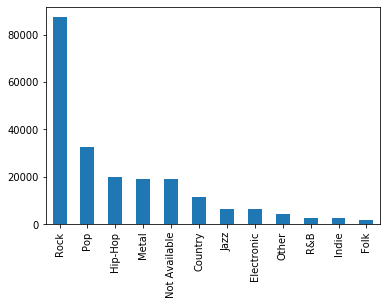

In [11]:
class_count.plot(kind='bar')

In [0]:
delete_index = train[train['genre'] == 'Rock'].index

In [13]:
type(delete_index)

pandas.core.indexes.numeric.Int64Index

In [14]:
delete_index[:10]

Int64Index([0, 5, 6, 7, 8, 9, 11, 12, 13, 16], dtype='int64')

In [15]:
train.drop(delete_index[0:60000], inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [0]:
enhence_attributes = ['Folk', 'Indie','R&B']
for attr in enhence_attributes:
    tmp_data = train[train['genre'] == attr]
    for i in range(8):
        train = train.append(tmp_data)

In [0]:
enhence_attributes = ['Jazz', 'Electronic','Other']
for attr in enhence_attributes:
    tmp_data = train[train['genre'] == attr]
    for i in range(4):
        train = train.append(tmp_data)

<class 'pandas.core.series.Series'>
Pop              32383
Jazz             31710
Electronic       31580
Rock             27304
R&B              24633
Indie            22806
Other            20700
Hip-Hop          19950
Metal            19185
Not Available    19076
Folk             16416
Country          11455
Name: genre, dtype: int64


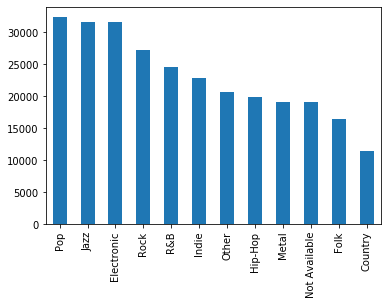

In [18]:
# explore the number of each genre
class_count = train['genre'].value_counts()
print(type(class_count))
print(class_count)
class_count.plot(kind='bar')

## Fraction

I start with a small dataset, 5% in order to build a pipline quickly.

In [0]:
# reset the index, otherwise, we will encounter errors 
#test.reset_index(drop=True, inplace=True)
#val.reset_index(drop=True, inplace=True)

#
train = train.sample(frac=1).reset_index(drop=True)
val = val.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)

In [20]:
ratio = 0.8
train_sample = train.loc[:int(len(train)*ratio),:]
val_sample = val.loc[:int(len(val)*ratio),:]
test_sample = test.loc[:int(len(test)*ratio),:]

print('size of train_sample', len(train_sample))
print('size of val_sample', len(val_sample))
print('size of test_sample', len(test_sample))

size of train_sample 221759
size of val_sample 21325
size of test_sample 21326


# Preprocessing

In [21]:
def clean_context(ctx_in, has_target=False):
            replace_newline = re.compile("\n")
            replace_dot = re.compile("\.")
            replace_cite = re.compile("'")
            replace_frac = re.compile("[\d]*frac[\d]+")
            replace_num = re.compile("\s\d+\s")
            rm_context_tag = re.compile('<.{0,1}context>')
            rm_cit_tag = re.compile('\[[eb]quo\]')
            rm_misc = re.compile("[\[\]\$`()%/,\.:;-]")

            ctx = replace_newline.sub(' ', ctx_in)  # (' <eop> ', ctx)

            ctx = replace_dot.sub(' ', ctx)  # .sub(' <eos> ', ctx)
            ctx = replace_cite.sub(' ', ctx)  # .sub(' <cite> ', ctx)
            ctx = replace_frac.sub(' <frac> ', ctx)
            ctx = replace_num.sub(' <number> ', ctx)
            ctx = rm_cit_tag.sub(' ', ctx)
            ctx = rm_context_tag.sub('', ctx)
            ctx = rm_misc.sub('', ctx)

            word_list = [word for word in re.split('`|, | +|\? |! |: |; |\(|\)|_|,|\.|"|“|”|\'|\'', ctx.lower()) if word]
            return word_list

def lemmatize_data(input_data):
    # input is a list of string
    result = []
    wnl = WordNetLemmatizer()
    for token in input_data:
        result.append(wnl.lemmatize(token))
    return result 


import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import re
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')


def preprocess(Corpus,attr='lyrics'):
    stop_words = set(stopwords.words('english'))
    # Remove blank rows if any.
    Corpus[attr].dropna(inplace=True)
    Corpus[attr] = [lemmatize_data(clean_context(entry)) for entry in Corpus[attr]]
    Corpus[attr] = [' '.join([token for token in entry if token not in stop_words]) for entry in Corpus[attr]]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [22]:
preprocess(train_sample)
preprocess(val_sample)
preprocess(test_sample)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(result)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

In [23]:
train_sample

,index,song,year,artist,genre,lyrics
0,140917,hands-down,2015,dej-loaf,Other,verse 1 hand nigga gettin bread yea basquiat p...
1,253286,purify,2007,feeder,Rock,given everything innocence ha pulled u apart f...
2,493,my-belle,2015,cenk-r-lr-etin,Other,hug meä± sacrifice ä± love methis life sake wa...
3,14707,how-was-i-supposed-to-know,2011,cris-cab,Pop,picture armed know stabbing dark place go page...
4,361371,honey,2007,dean-martin,Jazz,see tree big grown friend long big laughed got...
...,...,...,...,...,...,...
221754,177031,the-city,2013,colin,Indie,chorus like city go round thing like city like...
221755,335014,take-me-back-home,2010,escape-directors,Folk,board train take east find western wind drove ...
221756,90341,ton-visage,2016,frasro-delavega,Other,quand en ville le grain se lã¨ve vent de nerf ...
221757,19319,the-prime-time-of-your-life,2005,daft-punk,Electronic,prime time life prime time life prime time lif...


## Encode label and tokens

### Build the dictionary

In [24]:
from collections import Counter
# Frequent count, keep the tokens above the threshold


count_words = Counter()

for words in train_sample['lyrics']:
    count_words.update(words.split(' '))

total_words = len(count_words)
sorted_words = count_words.most_common(total_words)

threshold = 20

print('original dictionaary size', total_words)
token_to_int = {}
token_to_int = {w:i+1 for i,(w,c) in enumerate(sorted_words) if c >= threshold}
token_to_int['PAD'] = 0

print('filtered dictionaary size', len(token_to_int))
token_to_int['UNK'] = len(token_to_int)

label_to_int = {}
for label in data['genre']:
    if label not in label_to_int:
        label_to_int[label] = len(label_to_int)

original dictionaary size 350074
filtered dictionaary size 41011


In [25]:
token_to_int['PAD']

0

### Encoding **function**

In [0]:
def encode(words,token_to_int):
    result = []
    for token in words.split(' '):
        if token not in token_to_int:
            result.append(token_to_int['UNK'])
        else:
            result.append(token_to_int[token])
    return result


In [0]:
datas = train_sample['lyrics'][0].split(' ')

In [28]:
token_to_int['hello']

690

In [29]:
encode(train_sample['lyrics'][0], token_to_int)

[226,
 618,
 63,
 53,
 487,
 1469,
 643,
 41011,
 3141,
 327,
 10593,
 1963,
 1409,
 122,
 932,
 319,
 1375,
 938,
 3555,
 440,
 3201,
 4051,
 917,
 863,
 3673,
 2,
 5043,
 203,
 2090,
 2007,
 53,
 1,
 53,
 4321,
 70,
 3,
 30,
 9557,
 62,
 3572,
 20963,
 3572,
 643,
 2414,
 74,
 35,
 136,
 576,
 108,
 801,
 11283,
 54,
 5916,
 370,
 16,
 17038,
 1673,
 568,
 826,
 18,
 1845,
 2,
 384,
 228,
 20,
 92,
 185,
 456,
 34171,
 18,
 63,
 53,
 487,
 1469,
 22,
 1195,
 93,
 441,
 1273,
 74,
 191,
 74,
 344,
 136,
 1983,
 86,
 13,
 8,
 146,
 54,
 226,
 555,
 8820,
 114,
 1473,
 6714,
 3220,
 4020,
 764,
 783,
 498,
 24,
 105,
 134,
 24,
 2793,
 73,
 81,
 27,
 166,
 495,
 211,
 13,
 114,
 2681,
 5280,
 235,
 91,
 1050,
 226,
 569,
 562,
 491,
 69,
 603,
 16,
 591,
 136,
 16,
 2058,
 1214,
 20,
 4704,
 105,
 8,
 591,
 3744,
 34171,
 226,
 1201,
 1362,
 1395,
 584,
 4899,
 1141,
 2075,
 11343,
 398,
 391,
 211,
 696,
 105,
 228,
 209,
 229,
 20964,
 6,
 90,
 398,
 90,
 733,
 89,
 10,
 41011,
 5869,

In [30]:
# encode lyrics
train_sample['lyrics'] = [encode(words, token_to_int) for words in train_sample['lyrics']]
val_sample['lyrics'] = [encode(words, token_to_int) for words in val_sample['lyrics']]
test_sample['lyrics'] = [encode(words, token_to_int) for words in test_sample['lyrics']]

# encode labels
train_sample['genre'] = [label_to_int[label] for label in train_sample['genre']]
val_sample['genre'] = [label_to_int[label] for label in val_sample['genre']]
test_sample['genre'] = [label_to_int[label] for label in test_sample['genre']]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [31]:
#check
val_sample

,index,song,year,artist,genre,lyrics
0,204743,cumberland-river,2008,dailey-and-vincent,1,"[120, 116, 6369, 25903, 3103, 1916, 23785, 224..."
1,328109,in-bloom,2008,dark-lotus,5,"[12108, 69, 1059, 2368, 207, 125, 15986, 41011..."
2,11531,wine,2007,conway-twitty,0,"[676, 379, 385, 676, 379, 385, 676, 379, 385, ..."
3,217096,burning-down-the-billboards,2007,cave-in,0,"[21706, 114, 630, 7, 114, 3400, 63, 1452, 2352..."
4,282454,things-will-change,2014,gallon-drunk,0,"[36, 153, 267, 16, 13, 153, 267, 18, 267, 1364..."
...,...,...,...,...,...,...
21320,113534,coma,2007,eighteen-visions,0,"[386, 10743, 1852, 344, 196, 144, 524, 60, 98,..."
21321,318593,i-m-your-woman,2007,connie-smith,2,"[148, 66, 11928, 4, 59, 209, 3365, 425, 27, 49..."
21322,28859,to-a-friend,2007,alexisonfire,3,"[346, 8, 5, 2887, 1423, 418, 55, 3873, 50, 411..."
21323,77151,walk-forever-by-my-side,2007,the-alarm,0,"[148, 188, 174, 15, 268, 586, 25, 108, 2306, 8..."


## Padding

In [0]:
def pad_features(data, pad_length=100, left=True):
    features = [0 for i in range(pad_length)]

    num = min(len(data), pad_length)
    if left:
        features[:num] = data[:num]
    else:
        features[len(features)-num:] = data[:num]
    return features


In [33]:
# encode lyrics
pad_length = 100
train_sample['lyrics'] = [pad_features(words, pad_length) for words in train_sample['lyrics']]
val_sample['lyrics'] = [pad_features(words, pad_length) for words in val_sample['lyrics']]
test_sample['lyrics'] = [pad_features(words, pad_length) for words in test_sample['lyrics']]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



In [34]:
train_sample['lyrics'][1]

[920,
 86,
 2059,
 75,
 1445,
 45,
 415,
 64,
 41011,
 337,
 549,
 559,
 27,
 15,
 988,
 18,
 7,
 340,
 781,
 33,
 21,
 457,
 1551,
 80,
 76,
 428,
 520,
 1373,
 1373,
 103,
 19,
 80,
 76,
 332,
 570,
 570,
 260,
 465,
 260,
 465,
 260,
 465,
 12,
 181,
 515,
 1574,
 71,
 437,
 15,
 2,
 740,
 2952,
 1320,
 4040,
 8914,
 21,
 383,
 15,
 988,
 18,
 7,
 340,
 781,
 33,
 21,
 457,
 1551,
 80,
 76,
 428,
 520,
 1373,
 1373,
 103,
 19,
 80,
 76,
 332,
 570,
 570,
 260,
 465,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

## Convert to pytorch dataset

In [0]:
import torch 
from torch.utils.data import DataLoader, TensorDataset

train_data = TensorDataset(torch.tensor(train_sample['lyrics']),
                           torch.tensor(train_sample['genre']))

val_data = TensorDataset(torch.tensor(val_sample['lyrics']),
                           torch.tensor(val_sample['genre']))

test_data = TensorDataset(torch.tensor(test_sample['lyrics']),
                           torch.tensor(test_sample['genre']))

batch_size = 50

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
valid_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size, drop_last=True) 
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=True)

In [36]:
# obtain one batch of training data 
dataiter = iter(train_loader) 
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size())
print('Sample input: \n', sample_x) 
print() 
print('Sample label size: ', sample_y.size()) # batch_size 
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([50, 100])
Sample input: 
 tensor([[11501,  3620,  2603,  ...,  3497,   132,  6529],
        [  782,   445,   480,  ...,     0,     0,     0],
        [  646,    43,  1171,  ...,     0,     0,     0],
        ...,
        [ 4855,   572,  1284,  ...,     0,     0,     0],
        [  723,     0,     0,  ...,     0,     0,     0],
        [ 2071,   397,   174,  ...,     0,     0,     0]])

Sample label size:  torch.Size([50])
Sample label: 
 tensor([ 4, 11,  7,  7,  8,  1,  1,  8,  7,  0,  4,  2,  4,  2,  9, 11,  7,  7,
         4,  8,  2,  9, 10,  7,  4, 11, 10,  8,  7,  9, 10,  1,  4,  0,  1, 10,
        11,  1, 10,  8,  7,  1,  4,  0, 11, 11, 10,  6,  1, 11])


# Model

In [37]:
len(token_to_int)

41012

In [0]:
# config.py

class Config(object):
    embed_size = 300
    hidden_layers = 2
    hidden_size = 256
    bidirectional = True
    output_size = 12
    max_epochs = 30
    lr = 0.1
    batch_size = 50
    max_sen_len = 100 # Sequence length for RNN
    dropout_keep = 0.5

In [0]:
def evaluate_model(model, iterator):
    all_preds = []
    all_y = []
    for idx,batch in enumerate(iterator):
        if torch.cuda.is_available():
            x = batch[0].cuda()
        else:
            x = batch[0]
        y_pred = model(x)
        predicted = torch.max(y_pred.cpu().data, 1)[1] + 1
        all_preds.extend(predicted.numpy())
        all_y.extend(batch[1].numpy())
    score = accuracy_score(all_y, np.array(all_preds).flatten())
    return score

In [0]:
# model.py

import torch
from torch import nn
import numpy as np

class TextRNN(nn.Module):
    def __init__(self, config, vocab_size, word_embeddings):
        super(TextRNN, self).__init__()
        self.config = config
        
        # Embedding Layer
        self.embeddings = nn.Embedding(vocab_size, self.config.embed_size)
        self.embeddings.weight = nn.Parameter(word_embeddings, requires_grad=False)
        
        self.lstm = nn.LSTM(input_size = self.config.embed_size,
                            hidden_size = self.config.hidden_size,
                            num_layers = self.config.hidden_layers,
                            dropout = self.config.dropout_keep,
                            batch_first=True)
        
        self.dropout = nn.Dropout(self.config.dropout_keep)
        
       
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
        # linear and sigmoid layers
        self.fc = nn.Linear(self.config.hidden_size, 12)
        #self.sig = nn.Softmax(dim=1)
        

    def forward(self, x):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        embeds = self.embeddings(x)
        hidden = self.init_hidden(batch_size)

        lstm_out, hidden = self.lstm(embeds)

        #print('final_cell_state lstm_out shape', lstm_out.shape)
        # stack up lstm outputs
        lstm_out = lstm_out[:, -1,:].squeeze()
        lstm_out = lstm_out.contiguous().view(-1, self.config.hidden_size)
        #print('lstm_out', lstm_out.shape)
        #print('hidden', hidden)
        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        # sigmoid function
        #sig_out = self.sig(out)
        
        # reshape to be batch_size first
        #sig_out = sig_out.view(batch_size, -1)
        #sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return out    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(batch_size,self.config.hidden_layers, self.config.hidden_size)
        return hidden
    
    def add_optimizer(self, optimizer):
        self.optimizer = optimizer
        
    def add_loss_op(self, loss_op):
        self.loss_op = loss_op
    
    def reduce_lr(self):
        print("Reducing LR")
        for g in self.optimizer.param_groups:
            g['lr'] = g['lr'] / 2
                
    def run_epoch(self, train_iterator, val_iterator, epoch):
        train_losses = []
        val_accuracies = []
        losses = []
        
        # Reduce learning rate as number of epochs increase
        if (epoch == int(self.config.max_epochs/3)) or (epoch == int(2*self.config.max_epochs/3)):
            self.reduce_lr()
            
        for i, batch in enumerate(train_iterator):
            self.optimizer.zero_grad()
            if torch.cuda.is_available():
                x = batch[0].cuda()
                y = batch[1].type(torch.cuda.LongTensor)
            else:
                x = batch[0]
                y = batch[1].type(torch.LongTensor)

            y_pred = self.__call__(x)

            loss = self.loss_op(y_pred, y)
            loss.backward()
            losses.append(loss.data.cpu().numpy())
            self.optimizer.step()
    
            if i % 1500 == 0:
                print("Iter: {}".format(i+1))
                avg_train_loss = np.mean(losses)
                train_losses.append(avg_train_loss)
                print("\tAverage training loss: {:.5f}".format(avg_train_loss))
                losses = []
                
                # Evalute Accuracy on validation set
                val_accuracy = evaluate_model(self, val_iterator)
                print("\tVal Accuracy: {:.4f}".format(val_accuracy))
                self.train()
                
        return train_losses, val_accuracies

In [41]:
res = fill_with_gloves(token_to_int, path='./glove.6B.300d.txt', emb_size=300, vocab_size='6B', wordvecs=None)
res.shape

n words not found in glove word vectors: 12296


(41012, 300)

In [0]:
# train.py

import sys
import torch.optim as optim
from torch import nn
import torch

if __name__=='__main__':
    
    config = Config()
    # Create Model with specified optimizer and loss function
    ##############################################################
    model = TextRNN(config, len(token_to_int), torch.from_numpy(res))
    if torch.cuda.is_available():
        model.cuda()
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=config.lr)
    NLLLoss = torch.nn.CrossEntropyLoss()
    model.add_optimizer(optimizer)
    model.add_loss_op(NLLLoss)
    ##############################################################
    
    train_losses = []
    val_accuracies = []
    
    for i in range(config.max_epochs):
        print ("Epoch: {}".format(i))
        train_loss,val_accuracy = model.run_epoch(train_loader, valid_loader, i)
        train_losses.append(train_loss)
        val_accuracies.append(val_accuracy)

    train_acc = evaluate_model(model, train_loader)
    val_acc = evaluate_model(model, valid_loader)
    test_acc = evaluate_model(model, test_loader)

    print ('Final Training Accuracy: {:.4f}'.format(train_acc))
    print ('Final Validation Accuracy: {:.4f}'.format(val_acc))
    print ('Final Test Accuracy: {:.4f}'.format(test_acc))

Epoch: 0
Iter: 1
	Average training loss: 2.48149
	Val Accuracy: 0.0194
Iter: 1501
	Average training loss: 3.92200
	Val Accuracy: 0.0272
Iter: 3001
	Average training loss: 3.58911
	Val Accuracy: 0.0464
Epoch: 1
Iter: 1
	Average training loss: 3.88360
	Val Accuracy: 0.0474
Iter: 1501
	Average training loss: 3.81020
	Val Accuracy: 0.0613
Iter: 3001
	Average training loss: 3.57414
	Val Accuracy: 0.0313
Epoch: 2
Iter: 1
	Average training loss: 3.11340
	Val Accuracy: 0.0354
Iter: 1501
	Average training loss: 3.46352
	Val Accuracy: 0.0260


In [46]:
    train_acc = evaluate_model(model, train_loader)
    #val_acc = evaluate_model(model, valid_loader)
    #test_acc = evaluate_model(model, test_loader)

    print ('Final Training Accuracy: {:.4f}'.format(train_acc))
    #print ('Final Validation Accuracy: {:.4f}'.format(val_acc))
    #print ('Final Test Accuracy: {:.4f}'.format(test_acc))

Final Training Accuracy: 0.0531


In [0]:
import torch.nn as nn
import torch.nn.functional as F
class SentimentLSTM(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers,weights, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(weights, requires_grad=False) # Assigning the look-up table to the pre-trained GloVe word embedding.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        #self.sig = nn.Softmax(dim=1)
        

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        embeds = self.embedding(x)

        lstm_out, hidden = self.lstm(embeds, hidden)

        #print('final_cell_state lstm_out shape', lstm_out.shape)
        # stack up lstm outputs
        lstm_out = lstm_out[:, -1,:].squeeze()
        #print('lstm_out', lstm_out.shape)
        #print('hidden', hidden)
        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        # sigmoid function
        #sig_out = self.sig(out)
        
        # reshape to be batch_size first
        #sig_out = sig_out.view(batch_size, -1)
        #sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden
        

In [0]:
res = fill_with_gloves(token_to_int, path='./glove.6B.300d.txt', emb_size=300, vocab_size='6B', wordvecs=None)
# Instantiate the model w/ hyperparams
vocab_size = len(token_to_int)+1 # +1 for the 0 padding
output_size = len(label_to_int)
embedding_dim = 300
hidden_dim = 256
n_layers = 2
net = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers,torch.from_numpy(res))
print(net)


In [0]:
# loss and optimization functions
lr=0.001
train_on_gpu = False

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)


# training params

epochs = 4 # 3-4 is approx where I noticed the validation loss stop decreasing

counter = 0
print_every = 30
clip=5 # gradient clipping

# move model to GPU, if available
if(train_on_gpu):
    net.cuda()



# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    h = net.init_hidden(batch_size)
    # batch loop
    print('hello world----------------------------------------------------')
    for inputs, labels in train_loader:
        counter += 1
        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        # initialize hidden state
        #print(inputs.shape)
        
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        inputs = inputs.type(torch.LongTensor)
        output, h = net(inputs, h)

        # calculate the loss and perform backprop
        print('shapes-----------------',output.shape, labels.shape)
        #print(output)
        loss = criterion(output, labels)
        print(loss)
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss

            val_h = net.init_hidden(inputs.shape[0])
            val_losses = []
            net.eval()

            for inputs, labels in valid_loader:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                
                val_h = tuple([each.data for each in val_h])

                if(train_on_gpu):
                    inputs, labels = inputs.cuda(), labels.cuda()

                inputs = inputs.type(torch.LongTensor)
                output, val_h = net(inputs, val_h)
                val_loss = criterion(output, labels)

                val_losses.append(val_loss.item())

            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

In [0]:
criterion = torch.nn.CrossEntropyLoss()
loss = criterion([0.5,0.5],[1,0.5])
loss

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F

class LSTMClassifier(nn.Module):
	def __init__(self, batch_size, output_size, hidden_size, vocab_size, embedding_length, weights):
		super(LSTMClassifier, self).__init__()
		
		"""
		Arguments
		---------
		batch_size : Size of the batch which is same as the batch_size of the data returned by the TorchText BucketIterator
		output_size : 2 = (pos, neg)
		hidden_sie : Size of the hidden_state of the LSTM
		vocab_size : Size of the vocabulary containing unique words
		embedding_length : Embeddding dimension of GloVe word embeddings
		weights : Pre-trained GloVe word_embeddings which we will use to create our word_embedding look-up table 
		
		"""
		
		self.batch_size = batch_size
		self.output_size = output_size
		self.hidden_size = hidden_size
		self.vocab_size = vocab_size
		self.embedding_length = embedding_length
		
		self.word_embeddings = nn.Embedding(vocab_size, embedding_length)# Initializing the look-up table.
		self.word_embeddings.weight = nn.Parameter(weights, requires_grad=False) # Assigning the look-up table to the pre-trained GloVe word embedding.
		self.lstm = nn.LSTM(embedding_length, hidden_size)
		self.label = nn.Linear(hidden_size, output_size)
		
	def forward(self, input_sentence, batch_size=None):
	
		""" 
		Parameters
		----------
		input_sentence: input_sentence of shape = (batch_size, num_sequences)
		batch_size : default = None. Used only for prediction on a single sentence after training (batch_size = 1)
		
		Returns
		-------
		Output of the linear layer containing logits for positive & negative class which receives its input as the final_hidden_state of the LSTM
		final_output.shape = (batch_size, output_size)
		
		"""
		
		''' Here we will map all the indexes present in the input sequence to the corresponding word vector using our pre-trained word_embedddins.'''
		input = self.word_embeddings(input_sentence) # embedded input of shape = (batch_size, num_sequences,  embedding_length)
		input = input.permute(1, 0, 2) # input.size() = (num_sequences, batch_size, embedding_length)
		if batch_size is None:
			h_0 = Variable(torch.zeros(1, self.batch_size, self.hidden_size).cuda()) # Initial hidden state of the LSTM
			c_0 = Variable(torch.zeros(1, self.batch_size, self.hidden_size).cuda()) # Initial cell state of the LSTM
		else:
			h_0 = Variable(torch.zeros(1, batch_size, self.hidden_size).cuda())
			c_0 = Variable(torch.zeros(1, batch_size, self.hidden_size).cuda())
		output, (final_hidden_state, final_cell_state) = self.lstm(input, (h_0, c_0))
		final_output = self.label(final_hidden_state[-1]) # final_hidden_state.size() = (1, batch_size, hidden_size) & final_output.size() = (batch_size, output_size)
		
		return final_output